Usando la siguiente API

https://www.nobelprize.org/organization/developer-zone-2/

Cuya documentacion se encuentra en

https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.0#/default/get_laureates

Voy a extraer datos y hacer un analisis parecido al de esta pagina:

https://blog.royalsloth.eu/posts/nobel-prize-in-numbers/

# Extraccion y transformacion de datos

In [242]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

La API tiene 2 endpoints principales:

- https://api.nobelprize.org/2.1/laureates
- https://api.nobelprize.org/2.1/nobelPrizes

El primero trae "premiados". Estos pueden ser personas u organizaciones.

El segundo trae premios en concreto.

Veamos un ejemplo de cada uno

In [243]:
prices = requests.get('https://api.nobelprize.org/2.1/nobelPrizes').json()
laureates = requests.get('https://api.nobelprize.org/2.1/laureates').json()

In [244]:
prices.keys()

dict_keys(['nobelPrizes', 'meta', 'links'])

In [245]:
laureates.keys()

dict_keys(['laureates', 'meta', 'links'])

In [246]:
laureates['links'] # No sirven.

{'first': 'http://nobel-external-api-app.azurewebsites.net/2.1/laureates?offset=0&limit=25',
 'self': 'http://nobel-external-api-app.azurewebsites.net/2.1/laureates?offset=0&limit=25',
 'next': 'http://nobel-external-api-app.azurewebsites.net/2.1/laureates?offset=25&limit=25',
 'last': 'http://nobel-external-api-app.azurewebsites.net/2.1/laureates?offset=975&limit=25'}

Los endpoints retornan 25 premios o 25 premiados. Ademas de ello metadatos de la request y links con informacion respecto a la paginacion de la api. Estos nos van a servir para ir pasando de pagina.

Considero que el endpoint de los premiados es mas relevante y directo para el analisis, por lo que voy a seguir con ese. Una cosa a tener en cuenta es que los links que retorna la request arrojan errores de permisos 403. En teoria la api es publica y no requiere credenciales para acceder a los datos, por lo que creo que estan mal indicados ya que usando la url base y agregando los parametros se retornan los datos de forma correcta.

Usaremos de url base la siguiente https://api.nobelprize.org/2.1/laureates

E iremos pasando de pagina agregando offset y limit. Por ejemplo https://api.nobelprize.org/2.1/laureates?offset=50&limit=25

Veamos un ejemplo en concreto de lo que se retorna.

In [247]:
print(f"Cantidad de premiados {len(laureates['laureates'])}")
print(f"Informacion para cada premiado:\n {laureates['laureates'][4].keys()}")

Cantidad de premiados 25
Informacion para cada premiado:
 dict_keys(['id', 'knownName', 'givenName', 'familyName', 'fullName', 'fileName', 'gender', 'birth', 'wikipedia', 'wikidata', 'sameAs', 'links', 'nobelPrizes'])


Notar que **laureates['laureates']** es una lista de diccionarios.

Veamos cada key en detalle. Tomamos un ejemplo de la respuesta e inspeccionamos. 


In [248]:
for k in laureates['laureates'][1].keys():
    print(k, laureates['laureates'][1][k],'\n')

id 102 

knownName {'en': 'Aage N. Bohr', 'se': 'Aage N. Bohr'} 

givenName {'en': 'Aage N.', 'se': 'Aage N.'} 

familyName {'en': 'Bohr', 'se': 'Bohr'} 

fullName {'en': 'Aage Niels Bohr', 'se': 'Aage Niels Bohr'} 

fileName bohr 

gender male 

birth {'date': '1922-06-19', 'place': {'city': {'en': 'Copenhagen', 'no': 'København', 'se': 'Köpenhamn'}, 'country': {'en': 'Denmark', 'no': 'Danmark', 'se': 'Danmark'}, 'cityNow': {'en': 'Copenhagen', 'no': 'København', 'se': 'Köpenhamn', 'sameAs': ['https://www.wikidata.org/wiki/Q1748', 'https://www.wikipedia.org/wiki/Copenhagen'], 'latitude': '55.678127', 'longitude': '12.572532'}, 'countryNow': {'en': 'Denmark', 'no': 'Danmark', 'se': 'Danmark', 'sameAs': ['https://www.wikidata.org/wiki/Q35'], 'latitude': '56.000000', 'longitude': '10.000000'}, 'continent': {'en': 'Europe', 'no': 'Europa', 'se': 'Europa'}, 'locationString': {'en': 'Copenhagen, Denmark', 'no': 'København, Danmark', 'se': 'Köpenhamn, Danmark'}}} 

death {'date': '2009-09-08

Campos de interes que vamos a extraer para cada laureado:

knownName, gender, birth_date, birth_city, birth_country, birth_continent.

Ocurren varias cosas, entre ellas

- Los laureados pueden ser personas u organizaciones. Si son organizaciones los datos vienen con otros nombres de keys.
- Si la persona esta viva no viene la key 'death'. Si la organizacion se disolvio (murio) viene la key 'disolved', ademas no tienen genero.
- Algunos registros estan incompletos (faltan datos sobre la ciudad/pais/continente de nacimiento).

Todo esto se puede salvar, unificamos los nombres bajo un criterio y extraemos para cada caso persona/organizacion segun corresponda. Decimos que una organizacion tiene gender organization, que una persona/organizacion esta viva si no trae la key death/disolved, agregamos null values.

Una vez que extraemos todos los datos personales de interes que se disponen pasamos a los premios que gano ese laureado. Estos vienen en una lista. De esta lista extraemos mas campos relevantes:

awardYear, category, portion, prizeStatus, received, motivation, affiliate, etc..

Tambien son inconsistentes estos datos, algunos premios no registran affiliation. Permitimos nuevamente null values. El flujo de extraccion va a ser el siguiente:

1) Hacemos un request a la API con la url. Verificamos el codigo que retorna, extraemos si hay otra pagina para seguir haciendo requests o si debemos cortar el loop.
2) Obtenemos los datos de la request (los laureados). Iteramos sobre cada uno de los registros que trae la request. Para cada uno sacamos primero la informacion personal y luego iteramos sobre los premios que ha ganado, obteniendo la informacion de cada premio.
3) Guardamos la informacion. Si una persona/organizacion gano mas de un premio se van a repetir todos los datos personales, cambiando solo los del premio.
4) Aumentamos el offset y volvemos al inicio del loop. Si habia una 'next page' en el request realizado se vuelve a arrancar, si no se retorna la lista con todos los laureados y sus premios.

In [249]:
def extract_nobel_data():
    # Extraigo los laureates. Para cada uno de ellos voy a iterar sobre su(s) premio(s) y almacenarlo como un diccionario en una lista.
    offset = 0
    limit = 25
    next_url = True
    all_data = []
    while next_url:
        url = f'https://api.nobelprize.org/2.1/laureates?offset={offset}&limit={limit}'
        req = requests.get(url)
        if req.status_code == 200:
            data = req.json()
            # Extraigo si hay que hacer mas requests despues de esta
            next_url = data['links'].get('next',False)
            # Extraigo los laureates de esta request.
            for laureate in data['laureates']:
                laureate_id = laureate.get('id')
                    # Distinguir si es persona u organizacion. Sacar sus datos personales.            
                if 'knownName' in laureate:
                    # Es persona.
                    laureate_name = laureate.get('knownName').get('en')
                    laureate_gender = laureate.get('gender')
                    laureate_birth_date = laureate.get('birth').get('date')
                    # Si viene sin mas que la fecha de nacimiento va a arrojar error.
                    laureate_birth_city = laureate.get('birth').get('place',{}).get('cityNow',{}).get('en')
                    laureate_birth_country = laureate.get('birth').get('place',{}).get('countryNow',{}).get('en')
                    laureate_birth_continent = laureate.get('birth').get('place',{}).get('continent',{}).get('en')
                    laureate_alive = 0 if 'death' in laureate else 1
                else:
                    # Es organizacion.
                    laureate_name = laureate.get('orgName').get('en')
                    laureate_gender = 'organization'
                    laureate_birth_date = laureate.get('founded',{}).get('date')
                    laureate_birth_city = laureate.get('founded',{}).get('place',{}).get('city',{}).get('en')
                    laureate_birth_country = laureate.get('founded',{}).get('place',{}).get('city',{}).get('en')
                    laureate_birth_continent = laureate.get('founded',{}).get('place',{}).get('city',{}).get('en')
                    laureate_alive = 0 if 'dissolution' in laureate else 1
                # Iterar sobre sus premios.
                for prize in laureate.get('nobelPrizes'):
                    prize_year = prize.get('awardYear')
                    prize_category = prize.get('category').get('en')
                    prize_portion = prize.get('portion')
                    prize_status = prize.get('prizeStatus')
                    prize_motivation = prize.get('motivation').get('en')
                    prize_amount_adjusted = prize.get('prizeAmountAdjusted')
                    prize_sort_order = prize.get('sortOrder',1)
                    # Si viene sin affiliation va a arrojar error.
                    if prize.get('affiliations'):
                        prize_affiliation_name = prize.get('affiliations')[0].get('name', {}).get('en')
                        prize_affiliation_city = prize.get('affiliations')[0].get('cityNow', {}).get('en')
                        prize_affiliation_country = prize.get('affiliations')[0].get('countryNow', {}).get('en')
                    else:
                        prize_affiliation_name = None
                        prize_affiliation_city = None
                        prize_affiliation_country = None
                    # Fin de premio. Hay que agregarlo ahora al laureate con este premio.
                    all_data.append({
                        'id':laureate_id,
                        'name':laureate_name,
                        'gender':laureate_gender,
                        'birth_date':laureate_birth_date,
                        'birth_city':laureate_birth_city,
                        'birth_country':laureate_birth_country,
                        'birth_continent':laureate_birth_continent,
                        'alive':laureate_alive,
                        'prize_year':prize_year,
                        'prize_category':prize_category,
                        'prize_sort_order':prize_sort_order,
                        'prize_portion':prize_portion,
                        'prize_status':prize_status,
                        'prize_motivation':prize_motivation,
                        'prize_amount_adjusted':prize_amount_adjusted,
                        'prize_affiliation_name':prize_affiliation_name,
                        'prize_affiliation_city':prize_affiliation_city,
                        'prize_affiliation_country':prize_affiliation_country
                    })
                # Fin laureate. Paso al siguiente.
            # Fin laureates en request. Paso a la siguiente si existe, para eso corro el offset. Si no existe retorno la lista.
            offset += 25        
        else:
            print(f'Error {req.status_code}')
            return []
        
    return all_data

In [250]:
all_data = extract_nobel_data()

In [251]:
all_data[0]

{'id': '745',
 'name': 'A. Michael Spence',
 'gender': 'male',
 'birth_date': '1943-00-00',
 'birth_city': 'Montclair, NJ',
 'birth_country': 'USA',
 'birth_continent': 'North America',
 'alive': 1,
 'prize_year': '2001',
 'prize_category': 'Economic Sciences',
 'prize_sort_order': '2',
 'prize_portion': '1/3',
 'prize_status': 'received',
 'prize_motivation': 'for their analyses of markets with asymmetric information',
 'prize_amount_adjusted': 15114754,
 'prize_affiliation_name': 'Stanford University',
 'prize_affiliation_city': 'Stanford, CA',
 'prize_affiliation_country': 'USA'}

Me armo un data frame con todos los registros que se guardaron.

In [252]:
df = pd.DataFrame(all_data)
df.sample(5)

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country
132,1015,Carolyn Bertozzi,female,1966-10-10,"Boston, MA",USA,North America,1,2022,Chemistry,1,1/3,received,for the development of click chemistry and bio...,10852166,Stanford University,"Stanford, CA",USA
653,540,Mother Teresa,female,1910-08-26,Skopje,North Macedonia,Europe,0,1979,Peace,1,1,received,for her work for bringing help to suffering hu...,3673307,None,None,None
701,622,Pär Lagerkvist,male,1891-05-23,Växjö,Sweden,Europe,0,1951,Literature,1,1,received,for the artistic vigour and true independence ...,3302100,None,None,None
649,688,Milton Friedman,male,1912-07-31,"Brooklyn, NY",USA,North America,0,1976,Economic Sciences,1,1,received,for his achievements in the fields of consumpt...,4109175,University of Chicago,"Chicago, IL",USA
719,922,Paul Modrich,male,1946-06-13,"Raton, NM",USA,North America,1,2015,Chemistry,2,1/3,received,for mechanistic studies of DNA repair,10307434,Howard Hughes Medical Institute,"Durham, NC",USA


Inspecciono los tipos de datos que se almacenaron y transformo los que considero relevante.

In [253]:
df.dtypes

id                           object
name                         object
gender                       object
birth_date                   object
birth_city                   object
birth_country                object
birth_continent              object
alive                         int64
prize_year                   object
prize_category               object
prize_sort_order             object
prize_portion                object
prize_status                 object
prize_motivation             object
prize_amount_adjusted         int64
prize_affiliation_name       object
prize_affiliation_city       object
prize_affiliation_country    object
dtype: object

Paso a int:

- id
- prize_year.
- prize_sort_order
- birth_date. Lo hubiese pasado a datetime pero hay fechas fuera del rango que maneja pandas (OutOfBoundsDatetime). Ademas solo quiero el anio, para calcular la edad a la que gano el premio..

In [254]:
df.id = df.id.astype('int')
df.prize_year = df.prize_year.astype('int')
df.prize_sort_order = df.prize_sort_order.astype('int')

- Un registro tiene birth_date NaN.


In [255]:
df[df.birth_date.isna()] # Es 2013  segun wikipedia

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country
664,925,National Dialogue Quartet,organization,None,None,None,None,1,2015,Peace,1,1,received,for its decisive contribution to the building ...,10307434,None,None,None


In [256]:
df.loc[df.birth_date.isna(), ['birth_date']] = '2013-01-01'
df.birth_date = (df.birth_date).str[:4].astype('int')

<Axes: ylabel='Frequency'>

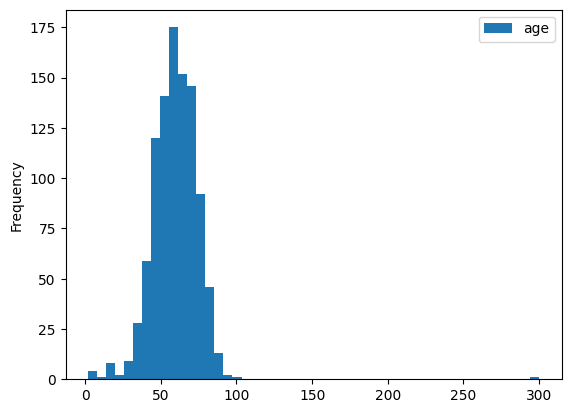

In [257]:
df['age'] = df.prize_year - df.birth_date
df.plot.hist(column='age', bins=50)

Mayormente son las organizaciones las que tienen edad muy baja o muy alta. Veamos la frecuencia por gender que hayan ganado un premio con edad menor a 20 o mayor a 90.

In [258]:
df[(df.age<20) | (df.age>90)]['gender'].value_counts()

gender
organization    14
male             2
female           1
Name: count, dtype: int64

# EDA

Dejamos la extraccion de datos por aca. Pasamos ahora a hacer un analisis exploratorio.

In [259]:
min_year = df.prize_year.min()
max_year = df.prize_year.max()
print(f"Los premios extraidos comienzan en el {min_year} y llegan hasta el {max_year}")

Los premios extraidos comienzan en el 1901 y llegan hasta el 2023


## Laureates by Gender

In [260]:
winners_by_gender = df.gender.value_counts()
winners_by_gender

gender
male            905
female           65
organization     30
Name: count, dtype: int64

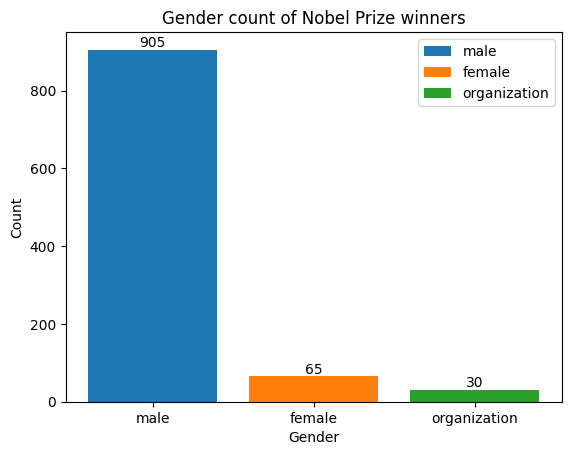

In [261]:
fig, ax = plt.subplots()
for g, c in winners_by_gender.items():
    b = ax.bar(x=g,height=c,label=g)
    ax.bar_label(b, label_type='edge')

ax.set_title("Gender count of Nobel Prize winners")
ax.legend()
ax.set_ylabel("Count")
ax.set_xlabel('Gender')
plt.show()

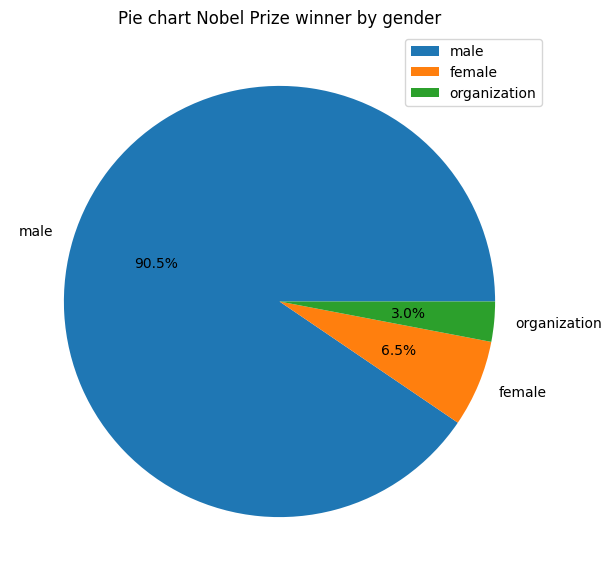

In [262]:
fig, ax = plt.subplots(figsize=(8,7))
ax.pie(winners_by_gender, labels=winners_by_gender.index, autopct='%1.1f%%')
ax.legend(loc='upper right')
ax.set_title('Pie chart Nobel Prize winner by gender')
plt.show()

In [263]:
winners_by_gender['total'] = winners_by_gender.sum()
winners_by_gender = pd.DataFrame(data = winners_by_gender)
winners_by_gender.columns = ['laureates']
winners_by_gender['percentage'] = round(winners_by_gender.laureates / winners_by_gender.laureates.max(),3) * 100
winners_by_gender

,laureates,percentage
gender,,
male,905,90.5
female,65,6.5
organization,30,3.0
total,1000,100.0


## Laureates Per Category and Gender

In [264]:
print("Categorias premiadas:" ,df.prize_category.unique())

print("Cantidad de categorias:", len(df.prize_category.unique()))

print("Cantidad de premiados: ", df.shape[0])

Categorias premiadas: ['Economic Sciences' 'Physics' 'Chemistry' 'Literature' 'Peace'
 'Physiology or Medicine']
Cantidad de categorias: 6
Cantidad de premiados:  1000


Como puede haber 1000 ganadores en 118 anios si solo hay 6 categorias? Las investigaciones no se realizan de forma individual, sino que mayormente en grupos de investigacion. Por lo tanto, a la hora de premiar una investigacion, se suele dar el premio a los directores de la investigacion.

Hacemos una tabla de frecuencias indexada por genero y en las columnas cada categoria.

In [265]:
category_by_gender = df.pivot_table(index='gender',columns='prize_category',values='id', aggfunc='count',fill_value=0)
category_by_gender

prize_category,Chemistry,Economic Sciences,Literature,Peace,Physics,Physiology or Medicine
gender,,,,,,
female,8,3,17,19,5,13
male,186,90,103,92,220,214
organization,0,0,0,30,0,0


In [266]:
category_by_gender.loc['total'] = category_by_gender.sum(axis=0)
category_by_gender

prize_category,Chemistry,Economic Sciences,Literature,Peace,Physics,Physiology or Medicine
gender,,,,,,
female,8,3,17,19,5,13
male,186,90,103,92,220,214
organization,0,0,0,30,0,0
total,194,93,120,141,225,227


Este tipo de graficos va a aparecer varias veces. Por lo tanto para plotearlos creo una funcion que generaliza la estructura.

In [267]:
def barplot_frequency_table(table,nrows,ncols,sharey,sharex,figsize, hue, hue_order,xlabel, xrotation=0):
    # Creo la grid.
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharey=sharey,sharex=sharex, figsize=figsize)
    ax = ax.flatten()
    for ind, column in enumerate(table.columns):
        # Relleno cada grid con barras segun la categoria.
        sns.barplot(x=table.index,y=table[column], ax=ax[ind],hue=hue,hue_order=hue_order)
        ax[ind].set_title(column)
        ax[ind].set_xlabel(xlabel)
        ax[ind].set_ylabel("Count")
        # Labels sobre las barras.
        for p in ax[ind].patches:
            ax[ind].annotate(f"{int(p.get_height())}", 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', color='black', 
                             xytext=(0, 5), textcoords='offset points')
        ax[ind].xaxis.set_ticks(range(len(hue_order)))
        ax[ind].set_xticklabels(hue, rotation=xrotation, ha='right')
    plt.show()

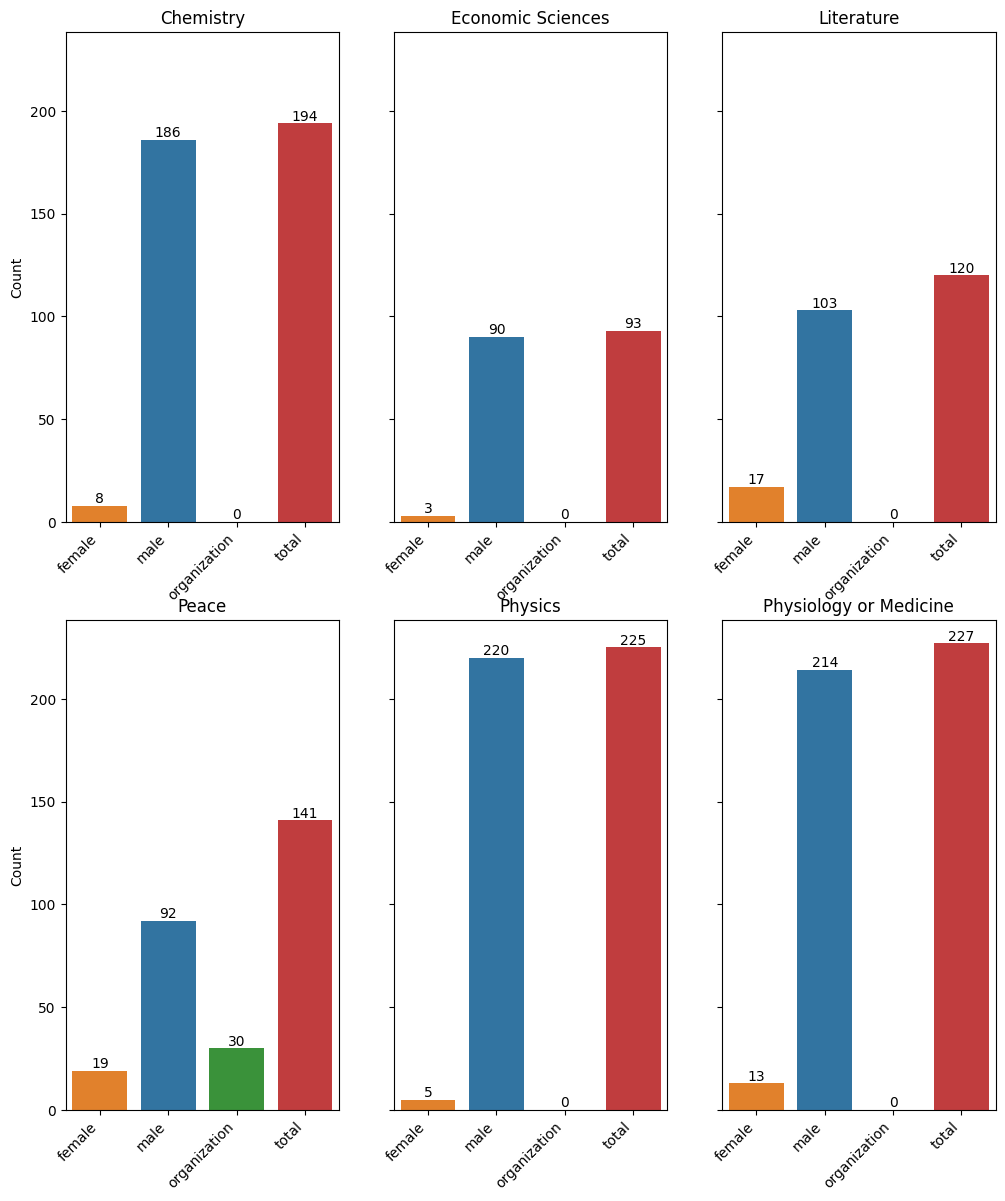

In [268]:
hue=category_by_gender.index
hue_order = ['male','female','organization','total']

barplot_frequency_table(table = category_by_gender, nrows = 2, ncols= 3, sharey = True, sharex = False, figsize = (12,14),
                       hue = hue, hue_order = hue_order, xlabel = '', xrotation=45)

## More than one prize

Existen personas / organizaciones que hayan ganado mas de un premio nobel? Lo averiguamos con el id de cada ganador. Contamos la frecuencia en que aparecen y si hay alguno con frecuencia mayor a 1.

In [269]:
(df.id.value_counts() > 1).sum() # Son 7.

np.int64(7)

In [270]:
mask = (df.id.value_counts() > 1).index[:7] # Esto me da los id que se repiten. No son los indices de las filas.
df.loc[df.id.isin(mask.values)][['name','prize_category','prize_year','gender']].sort_values(by=['name'])

,name,prize_category,prize_year,gender
287,Frederick Sanger,Chemistry,1958,male
288,Frederick Sanger,Chemistry,1980,male
418,International Committee of the Red Cross,Peace,1917,organization
419,International Committee of the Red Cross,Peace,1944,organization
420,International Committee of the Red Cross,Peace,1963,organization
487,John Bardeen,Physics,1956,male
488,John Bardeen,Physics,1972,male
533,K. Barry Sharpless,Chemistry,2001,male
534,K. Barry Sharpless,Chemistry,2022,male
582,Linus Pauling,Chemistry,1954,male


Vamos a plotear un grafico de barras horizontales con nombre, cantidad de premios que gano y el genero. 

Voy a necesitar un dataframe indexado por nombre con la columna gender y la cantidad de premios. Lo obtengo por partes. 

Hago un join de dos tablas, una con name y gender, la otra con name y cnt. Luego la indexo por nombre.

In [271]:
name_gender = pd.DataFrame(df.loc[df.id.isin(mask.values)][['name','gender']])
name_gender

,name,gender
287,Frederick Sanger,male
288,Frederick Sanger,male
418,International Committee of the Red Cross,organization
419,International Committee of the Red Cross,organization
420,International Committee of the Red Cross,organization
487,John Bardeen,male
488,John Bardeen,male
533,K. Barry Sharpless,male
534,K. Barry Sharpless,male
582,Linus Pauling,male


In [272]:
name_count = name_gender.groupby('name').size().reset_index(name='cnt')
name_count

,name,cnt
0,Frederick Sanger,2
1,International Committee of the Red Cross,3
2,John Bardeen,2
3,K. Barry Sharpless,2
4,Linus Pauling,2
5,Marie Curie,2
6,Office of the United Nations High Commissioner...,2


In [273]:
name_cnt_gender = name_count.merge(name_gender,on='name').drop_duplicates().sort_values(by=['cnt','gender'], ascending=False)
name_cnt_gender.set_index('name', inplace=True)
name_cnt_gender

,cnt,gender
name,,
International Committee of the Red Cross,3,organization
Office of the United Nations High Commissioner for Refugees,2,organization
Frederick Sanger,2,male
John Bardeen,2,male
K. Barry Sharpless,2,male
Linus Pauling,2,male
Marie Curie,2,female


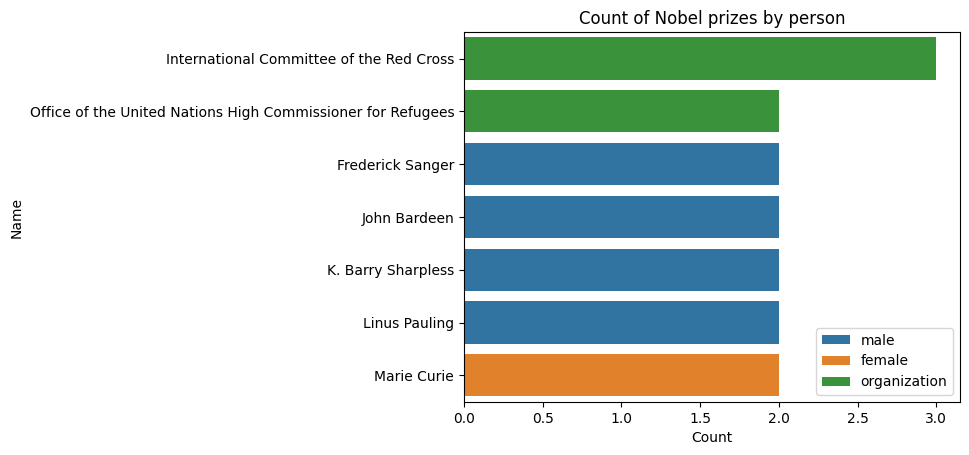

In [274]:
fig, ax = plt.subplots()

sns.barplot(name_cnt_gender, x='cnt',y='name',hue='gender', hue_order=hue_order[0:3], ax = ax)
ax.set_xlabel('Count')
ax.set_ylabel('Name')
ax.set_title('Count of Nobel prizes by person')
ax.legend()
plt.show()

## Declined Awards

Existen personas que no aceptaron el premio? Podemos averiguarlo usando la columna **prize_status**.

In [275]:
df.prize_status.unique()

array(['received', 'restricted', 'declined'], dtype=object)

No solo existen personas que rechazaron el premio, sino que las hay a las que le fue restringido el acceso. Veamos cuantas y quienes.

In [276]:
mask = df.prize_status != 'received'
not_received = df.loc[mask,['name','id','prize_year','prize_portion','prize_category','birth_country','prize_status']]
not_received.set_index('name')

,id,prize_year,prize_portion,prize_category,birth_country,prize_status
name,,,,,,
Boris Pasternak,629,1958,1,Literature,Russia,restricted
Jean-Paul Sartre,637,1964,1,Literature,France,declined
Le Duc Tho,531,1973,1/2,Peace,Vietnam,declined


In [277]:
df[(df.prize_year == 1973) & (df.prize_category == 'Peace')]

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country,age
388,530,Henry Kissinger,male,1923,Fürth,Germany,Europe,0,1973,Peace,1,1/2,received,for jointly having negotiated a cease fire in ...,4095993,None,None,None,50
566,531,Le Duc Tho,male,1911,Nam Ha province,Vietnam,Asia,0,1973,Peace,2,1/2,declined,for jointly having negotiated a cease fire in ...,4095993,None,None,None,62


- Pasternak, Ruso (URSS) en plena guerra fria.
- Tho, Vietnamita que ayudo a negociar la paz durante la guerra de vietnam.
- Sartre, en contra de la institucion.

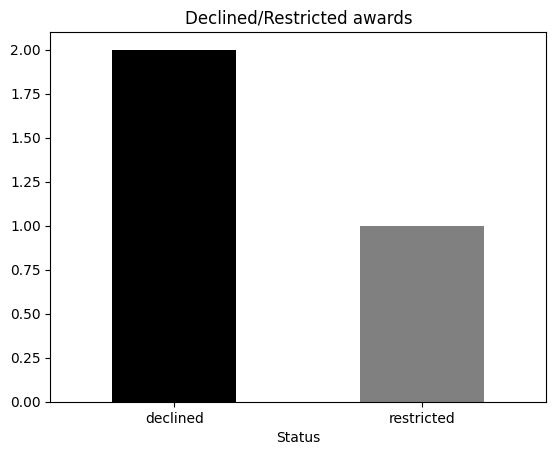

In [278]:
ser = not_received.groupby('prize_status')[['name']].aggregate('count').name
fig,ax = plt.subplots()
ser.plot.bar(color=['black','gray'], ax = ax)
ax.set_xlabel('Status')
ax.set_title('Declined/Restricted awards')
plt.xticks(rotation=0)
plt.show()

## Prize Money and Sharing



### Portion

Cuando se gana un Premio Nobel cada laureado recibe un diploma, una medalla y una cierta cantidad de dinero en coronas suizas. Esta cantidad depende de la forma en que se asigna el premio (a cuantas personas) y la forma en que luego se reparten el dinero. Todas las categorias asignan el mismo monto de dinero.

La columna **prize_portion** es la porcion del premio que se llevo la persona. Por ejemplo puede ocurrir que:

- un premio se reparte entre 3 personas. Una de ellas se lleva 1/2 y las otras dos 1/4 del premio.
- un premio se reparte entre 4 personas. Cada una se lleva 1/4.

Veamos cuales son las categorias donde uno puede ganar mas dinero, osea las que menos reparten el premio.

In [279]:
portion_by_category = df.pivot_table(index='prize_portion', values = 'id', columns=['prize_category'], aggfunc = {'id':'count'}, fill_value = 0)
portion_by_category

prize_category,Chemistry,Economic Sciences,Literature,Peace,Physics,Physiology or Medicine
prize_portion,,,,,,
1,63,26,112,70,47,40
1/2,58,41,8,62,84,78
1/3,57,24,0,9,54,93
1/4,16,2,0,0,40,16


In [280]:
portion_by_category.loc['total'] = portion_by_category.sum(axis=0)
portion_by_category

prize_category,Chemistry,Economic Sciences,Literature,Peace,Physics,Physiology or Medicine
prize_portion,,,,,,
1,63,26,112,70,47,40
1/2,58,41,8,62,84,78
1/3,57,24,0,9,54,93
1/4,16,2,0,0,40,16
total,194,93,120,141,225,227


Ploteamos esta tabla de frecuencias al igual que hicimos con gender y category. 

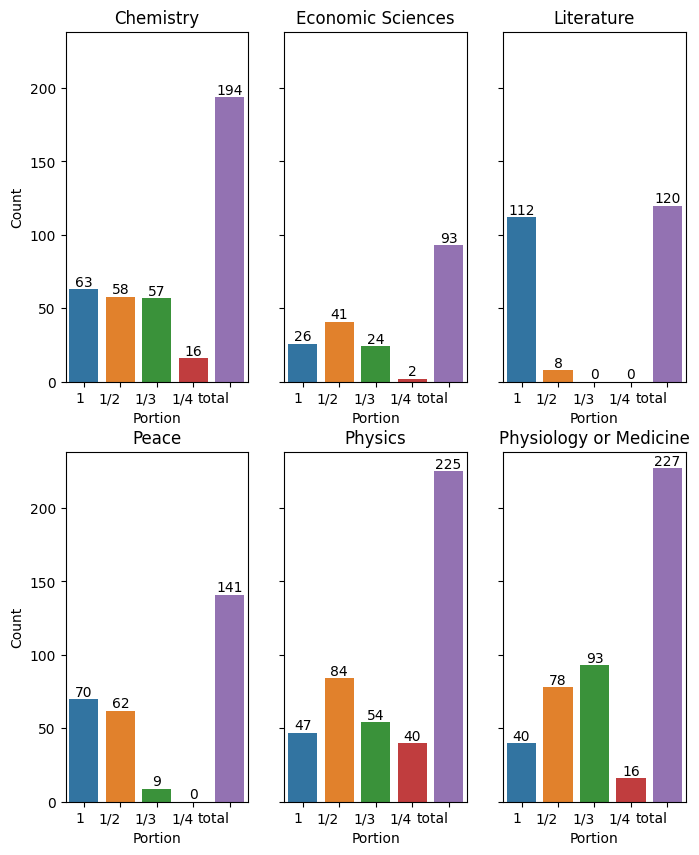

In [281]:
hue = ['1','1/2','1/3','1/4', 'total']
hue_order = hue
barplot_frequency_table(portion_by_category, nrows=2,ncols=3,sharey=True,sharex=False,figsize=(8,10),
                        hue=hue, hue_order = hue_order, xlabel='Portion')

De este grafico vemos que Medicina, Fisica y Quimica son las categorias mas colaborativas.

Veamoslo de forma tabular y en porcentajes. Para ello transpongo la matriz y luego divido por los totales de cada fila.

In [282]:
portion_by_category.T

prize_portion,1,1/2,1/3,1/4,total
prize_category,,,,,
Chemistry,63,58,57,16,194
Economic Sciences,26,41,24,2,93
Literature,112,8,0,0,120
Peace,70,62,9,0,141
Physics,47,84,54,40,225
Physiology or Medicine,40,78,93,16,227


In [283]:
round((portion_by_category.T.divide(portion_by_category.T.total,axis=0) * 100),2).sort_values(by='1',ascending=False)

prize_portion,1,1/2,1/3,1/4,total
prize_category,,,,,
Literature,93.33,6.67,0.00,0.00,100.0
Peace,49.65,43.97,6.38,0.00,100.0
Chemistry,32.47,29.90,29.38,8.25,100.0
Economic Sciences,27.96,44.09,25.81,2.15,100.0
Physics,20.89,37.33,24.00,17.78,100.0
Physiology or Medicine,17.62,34.36,40.97,7.05,100.0


Vemos que las categorias mas individuales, a la hora de repartir la plata, son Literatura y Paz. 

### Sharing

Ahora veamos si a lo largo del tiempo fue cambiando la tendencia de division de premios (la cantidad de gente que se le asigna a un premio). Para lograr esto voy a necesitar varias cosas.

Tengo que sacar el prize_sort_order maximo para cada premio. Veamoslo con un ejemplo.

In [284]:
df[(df.prize_year == 2020) & (df.prize_category == 'Physics')]

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country,age
58,990,Andrea Ghez,female,1965,"New York, NY",USA,North America,1,2020,Physics,3,1/4,received,for the discovery of a supermassive compact ob...,12017727,University of California,"Los Angeles, CA",USA,55
759,989,Reinhard Genzel,male,1952,Bad Homburg vor der Höhe,Germany,Europe,1,2020,Physics,2,1/4,received,for the discovery of a supermassive compact ob...,12017727,Max Planck Institute for Extraterrestrial Physics,Garching,Germany,68
815,988,Roger Penrose,male,1931,Colchester,United Kingdom,Europe,1,2020,Physics,1,1/2,received,for the discovery that black hole formation is...,12017727,University of Oxford,Oxford,United Kingdom,89


In [285]:
df.prize_sort_order.max()

np.int64(3)

Notar que, el premio de fisica de 2020 fue entregado a 3 personas y que no hay premios repartidos a mas de 3 personas. Para saber esto tenemos que quedarnos con el valor de sort_order maximo. 

Asi tenemos que operar sobre cada par (anio,categoria). Agrupo por anio,categoria y saco maximos.

In [286]:
prize_category_laureates = df.groupby(['prize_year','prize_category']).aggregate({'prize_sort_order':'max'})
prize_category_laureates

prize_sort_order
prize_year prize_category                          
1901       Chemistry                              1
           Literature                             1
           Peace                                  2
           Physics                                1
           Physiology or Medicine                 1
...                                             ...
2023       Economic Sciences                      1
           Literature                             1
           Peace                                  1
           Physics                                3
           Physiology or Medicine                 2

[621 rows x 1 columns]

De esta tabla tengo que extraer cada categoria y contar cuantos 1, 2 y 3 hay.

In [287]:
category_laureates_per_prize = prize_category_laureates.groupby(['prize_category', 'prize_sort_order']).size().unstack(fill_value=0)
category_laureates_per_prize

prize_sort_order,1,2,3
prize_category,,,
Chemistry,63,25,27
Economic Sciences,26,20,9
Literature,112,4,0
Peace,70,31,3
Physics,47,32,38
Physiology or Medicine,40,35,39


Agrego el total y ploteo.

In [288]:
category_laureates_per_prize['total'] = category_laureates_per_prize.sum(axis=1)
category_laureates_per_prize

prize_sort_order,1,2,3,total
prize_category,,,,
Chemistry,63,25,27,115
Economic Sciences,26,20,9,55
Literature,112,4,0,116
Peace,70,31,3,104
Physics,47,32,38,117
Physiology or Medicine,40,35,39,114


In [289]:
category_laureates_per_prize = round(category_laureates_per_prize.divide(category_laureates_per_prize['total'], axis = 0),2) * 100
category_laureates_per_prize.columns.rename('pctg_laureates_awarded', inplace=True)
category_laureates_per_prize.sort_values(by=1, ascending=False)

pctg_laureates_awarded,1,2,3,total
prize_category,,,,
Literature,97.0,3.0,0.0,100.0
Peace,67.0,30.0,3.0,100.0
Chemistry,55.0,22.0,23.0,100.0
Economic Sciences,47.0,36.0,16.0,100.0
Physics,40.0,27.0,32.0,100.0
Physiology or Medicine,35.0,31.0,34.0,100.0


Los resultados son los mismos, las categorias mas individuales (en cantidad de premiados por premio) son en las que menos se reparte el premio economicamente.

## Prize distribution

### Per country of birth

In [290]:
df.birth_country.value_counts()

birth_country
USA               292
United Kingdom     90
Germany            84
France             61
Sweden             30
                 ... 
Kenya               1
Latvia              1
Indonesia           1
Nigeria             1
Taiwan              1
Name: count, Length: 98, dtype: int64

Nos quedamos con el top 10 para plotear.

In [291]:
country_birth = df.birth_country.value_counts()[:10]

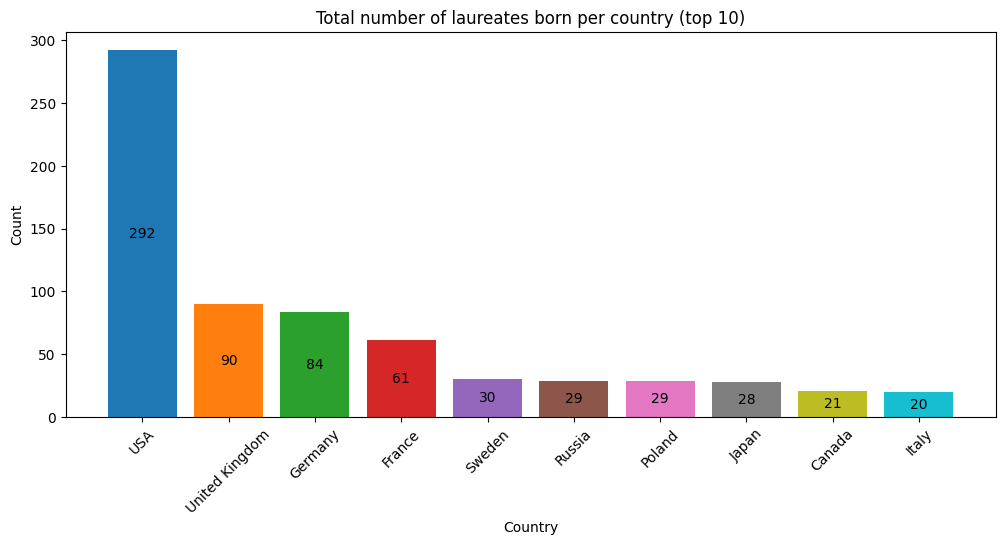

In [292]:
fig , ax = plt.subplots(figsize=(12,5))

for i,c in country_birth.items():
    b = ax.bar(x=i, height = c)
    ax.bar_label(b, label_type='center')

ax.set_title('Total number of laureates born per country (top 10)')
ax.set_ylabel('Count')
ax.set_xlabel('Country')
plt.xticks(rotation=45)
plt.show()

Veamos cuanto representan del total este top.

In [293]:
top_country_percentage = round(df.birth_country.value_counts() / df.birth_country.value_counts().sum() * 100,2)[:10]
top_country_percentage

birth_country
USA               29.41
United Kingdom     9.06
Germany            8.46
France             6.14
Sweden             3.02
Russia             2.92
Poland             2.92
Japan              2.82
Canada             2.11
Italy              2.01
Name: count, dtype: float64

In [294]:
top_country_percentage.sum()

np.float64(68.87)

Entre estos 10 paises de nacimiento contienen casi el 70% de los ganadores. Solo USA representa el 30%.

### Per continent of birth 

In [295]:
df.birth_continent.value_counts(dropna=False)

birth_continent
Europe              516
North America       323
Asia                 76
Africa               28
Oceania              15
South America        11
None                  7
Geneva                7
New York, NY          4
London                2
Paris                 2
Washington, D.C.      1
Dhaka                 1
Kyiv                  1
Ghent                 1
Vienna                1
Boston, MA            1
Moscow                1
Bern                  1
Pugwash               1
Name: count, dtype: int64

Los cambio a mano. Los missing values los inpsecciono y decido.

- Geneva, London, Paris, Kyiv, Ghent, Vienna, Bern  -> Europe
- New York, NY, Washington, D.C., Boston, MA, Pugwash -> North America
- Dhaka, Moscow -> Asia

In [296]:
df[df.birth_continent.isna()]

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country,age
4,1004,Abdulrazak Gurnah,male,1948,None,None,None,1,2021,Literature,1,1,received,for his uncompromising and compassionate penet...,11760204,None,None,None,73
258,881,European Union,organization,1952,None,None,None,1,2012,Peace,1,1,received,for over six decades contributed to the advanc...,10278707,None,None,None,60
416,948,International Campaign to Abolish Nuclear Weapons,organization,2007,None,None,None,1,2017,Peace,1,1,received,for its work to draw attention to the catastro...,11280587,None,None,None,10
417,564,International Campaign to Ban Landmines,organization,1992,None,None,None,1,1997,Peace,1,1/2,received,for their work for the banning and clearing of...,11768210,None,None,None,5
664,925,National Dialogue Quartet,organization,2013,None,None,None,1,2015,Peace,1,1,received,for its decisive contribution to the building ...,10307434,None,None,None,2
687,893,Organisation for the Prohibition of Chemical W...,organization,1997,None,None,None,1,2013,Peace,1,1,received,for its extensive efforts to eliminate chemica...,10284439,None,None,None,16
991,994,World Food Programme,organization,1961,None,None,None,1,2020,Peace,1,1,received,"for its efforts to combat hunger, for its cont...",12017727,None,None,None,59


La mayoria son organizaciones, las dejo asi. A la persona le asigno la que indica wikipedia..

In [297]:
eur = ['Geneva', 'London', 'Paris', 'Kyiv', 'Ghent', 'Vienna', 'Bern']
na = ['New York, NY','Washington, D.C.','Boston, MA', 'Pugwash']
a = ['Dhaka', 'Moscow']

In [298]:
df.loc[df.birth_continent.isin(eur), 'birth_continent'] = 'Europe'
df.loc[df.birth_continent.isin(na), 'birth_continent'] = 'North America'
df.loc[df.birth_continent.isin(a), 'birth_continent'] = 'Asia'
df.loc[df.id == 1004, 'birth_continent'] = 'Africa'
df.birth_continent.value_counts()

birth_continent
Europe           531
North America    330
Asia              78
Africa            29
Oceania           15
South America     11
Name: count, dtype: int64

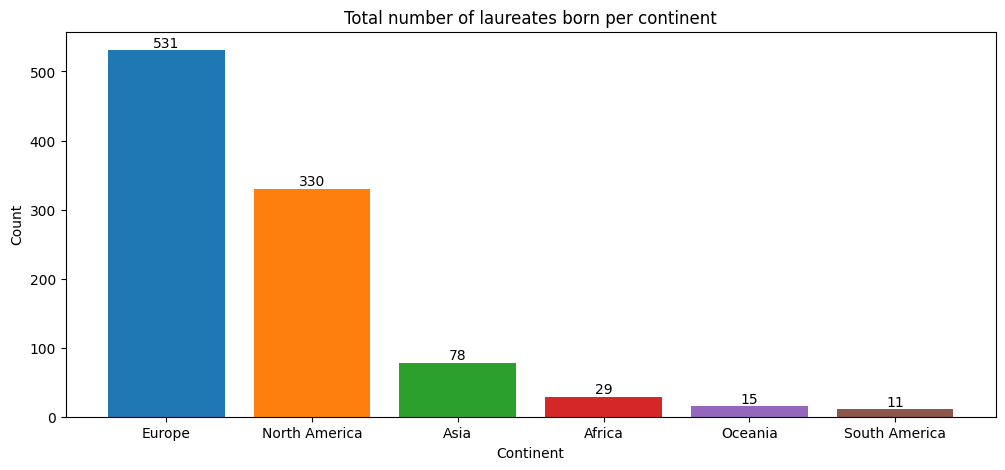

In [299]:
continent_birth = df.birth_continent.value_counts()

fig , ax = plt.subplots(figsize=(12,5))

for i,c in continent_birth.items():
    b = ax.bar(x=i, height = c)
    ax.bar_label(b, label_type='edge')

ax.set_title('Total number of laureates born per continent')
ax.set_ylabel('Count')
ax.set_xlabel('Continent')
plt.xticks(rotation=0)
plt.show()

Con un pie chart y en porcentaje

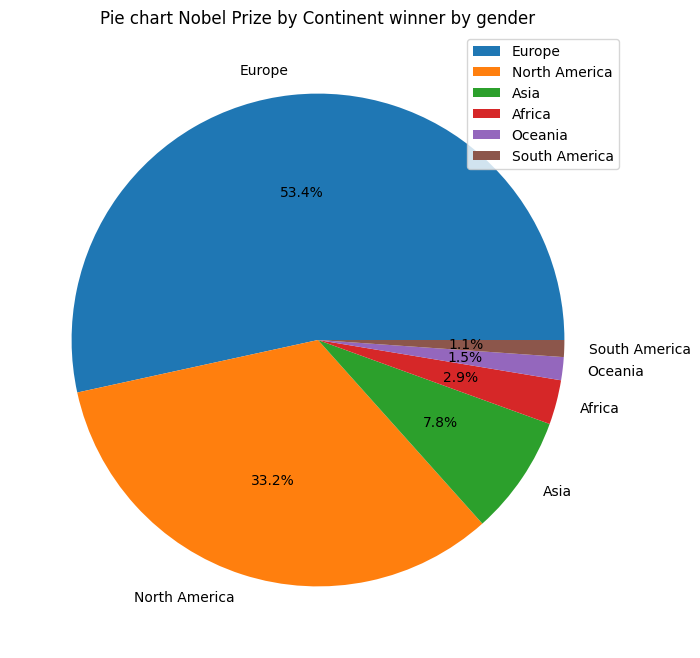

In [300]:
fig, ax = plt.subplots(figsize=(10,8))
ax.pie(continent_birth, labels=continent_birth.index, autopct='%1.1f%%')
ax.legend()
ax.set_title('Pie chart Nobel Prize by Continent winner by gender')
plt.show()

In [301]:
round(continent_birth / continent_birth.sum() * 100 , 1)

birth_continent
Europe           53.4
North America    33.2
Asia              7.8
Africa            2.9
Oceania           1.5
South America     1.1
Name: count, dtype: float64

Veamos si cada continente tiene una mayor area de especializacion.

In [302]:
birth_continent_category_freq = df.pivot_table(index='birth_continent',columns='prize_category',values='id', aggfunc='count',fill_value=0)
birth_continent_category_freq

prize_category,Chemistry,Economic Sciences,Literature,Peace,Physics,Physiology or Medicine
birth_continent,,,,,,
Africa,3,0,7,13,3,3
Asia,16,3,10,17,21,11
Europe,109,31,82,70,122,117
North America,63,59,17,30,77,84
Oceania,3,0,0,2,2,8
South America,0,0,4,3,0,4


In [303]:
birth_continent_category_freq.index.values

array(['Africa', 'Asia', 'Europe', 'North America', 'Oceania',
       'South America'], dtype=object)

In [304]:
continent_birth.index

Index(['Europe', 'North America', 'Asia', 'Africa', 'Oceania',
       'South America'],
      dtype='object', name='birth_continent')

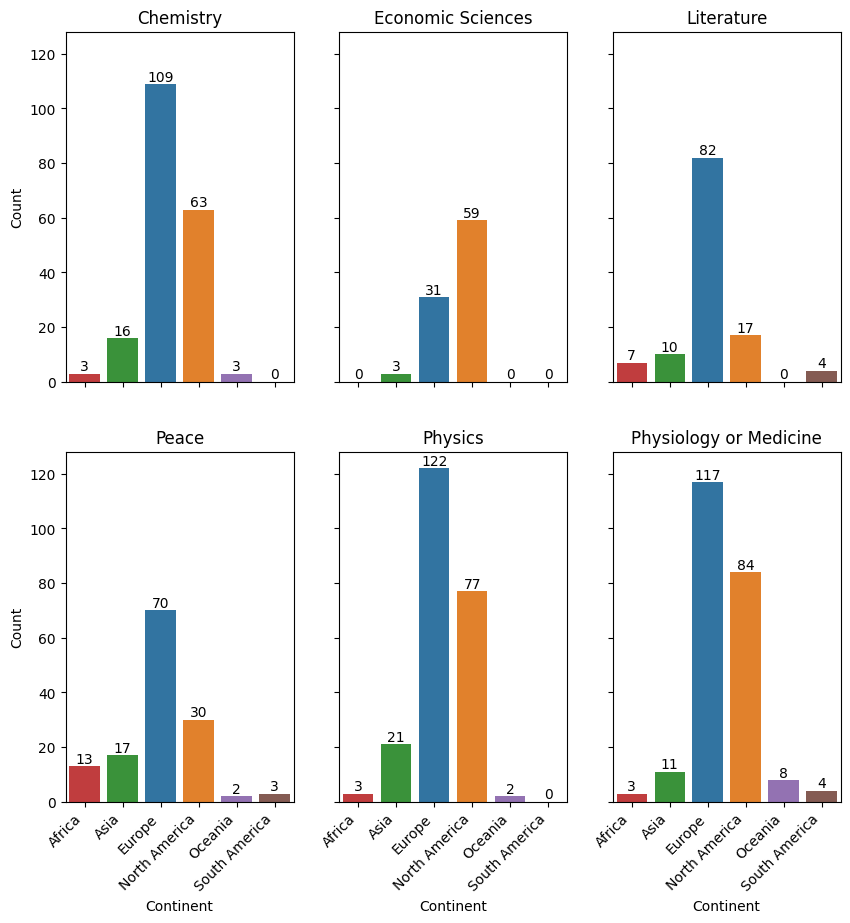

In [305]:
hue = birth_continent_category_freq.index.values
hue_order = continent_birth.index 
barplot_frequency_table(birth_continent_category_freq, nrows=2,ncols=3,sharey=True,sharex=True,figsize=(10,10),
                        hue=hue, hue_order = hue_order, xlabel='Continent', xrotation=45)

O hacemos por continente y detallado en categorias.

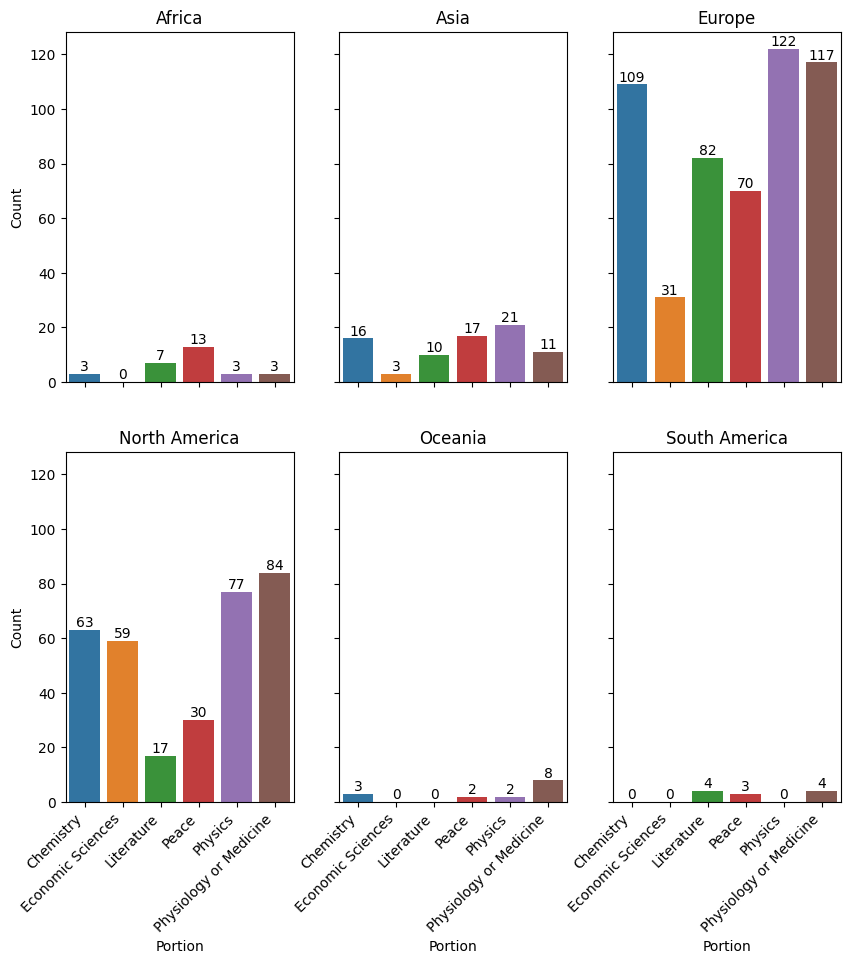

In [306]:
hue = birth_continent_category_freq.T.index.values
hue_order = hue
barplot_frequency_table(birth_continent_category_freq.T, nrows=2,ncols=3,sharey=True,sharex=True,figsize=(10,10),
                        hue=hue, hue_order = hue_order, xlabel='Portion', xrotation=45)

Ploteamos los porcentajes de cada pais sobre el total de cada categoria en un heatmap.

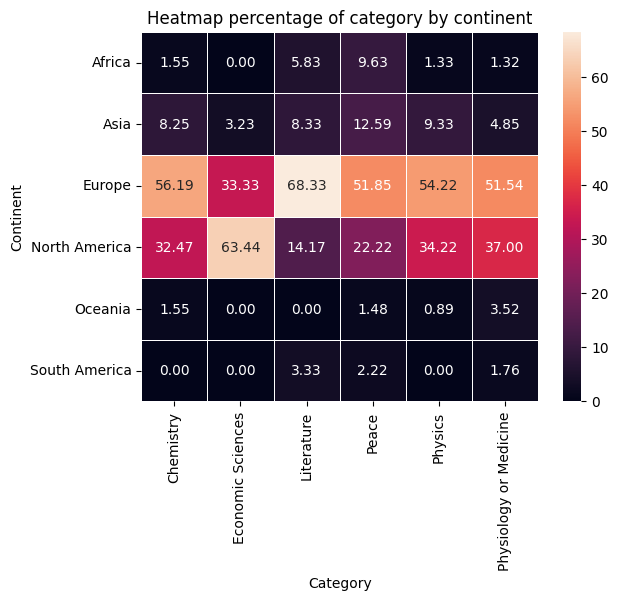

In [307]:
m = round(birth_continent_category_freq / birth_continent_category_freq.sum(axis=0) * 100, 2)
ax = sns.heatmap(m, annot = True, linewidth=.5, fmt=".2f")
ax.set(xlabel='Category', ylabel='Continent',title='Heatmap percentage of category by continent')
plt.show()

## Nobel Prize per affiliation

In [308]:
df.prize_affiliation_name.value_counts(dropna=False)

prize_affiliation_name
None                                                                           264
University of California                                                        36
Harvard University                                                              28
Massachusetts Institute of Technology (MIT)                                     22
Stanford University                                                             22
                                                                              ... 
University of Maryland, Department of Economics and School of Public Policy      1
Research Division of Infectious Diseases, Children's Medical Center              1
Tokyo Institute of Technology                                                    1
Institut Français du Pétrole                                                     1
A.F. Ioffe Physico-Technical Institute                                           1
Name: count, Length: 323, dtype: int64

In [309]:
df[df.prize_affiliation_name.isna()].prize_category.value_counts()

prize_category
Peace                     137
Literature                120
Economic Sciences           2
Chemistry                   2
Physics                     2
Physiology or Medicine      1
Name: count, dtype: int64

Tiene sentido, vimos que la mayoria de los premio nobel de la paz son personas individuales u organizaciones. No tienen una 'affiliation' (universidad u organismo que les financie los estudios).

In [310]:
abbreviations = {
    'University of California': 'UC',
    'Harvard University': 'Harvard',
    'Massachusetts Institute of Technology (MIT)': 'MIT',
    'Stanford University': 'Stanford',
    'University of Chicago': 'UChicago',
    'Columbia University': 'Columbia',
    'Princeton University': 'Princeton',
    'University of Cambridge': 'Cambridge',
    'California Institute of Technology (Caltech)': 'Caltech',
    'Rockefeller University': 'Rockefeller'
}

top_10_affiliations = df.prize_affiliation_name.value_counts()[:10].rename(index=abbreviations)
top_10_affiliations

prize_affiliation_name
UC             36
Harvard        28
MIT            22
Stanford       22
UChicago       19
Columbia       18
Princeton      17
Cambridge      17
Caltech        17
Rockefeller    13
Name: count, dtype: int64

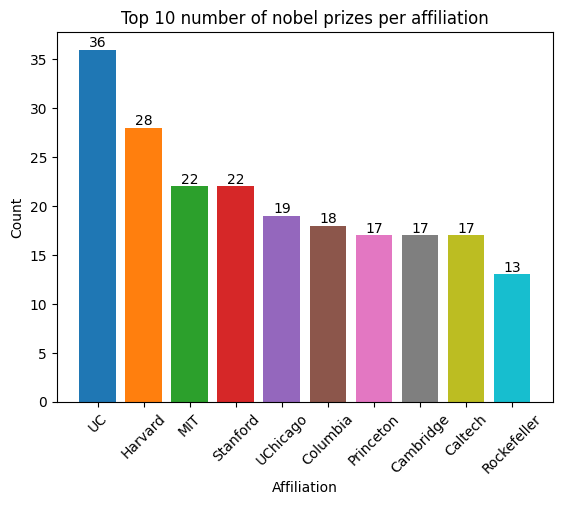

In [311]:
fig, ax = plt.subplots()
for i,c in top_10_affiliations.items():
    b = ax.bar(x=i, height = c)
    ax.bar_label(b, label_type='edge')

ax.set_title('Top 10 number of nobel prizes per affiliation')
ax.set_ylabel('Count')
ax.set_xlabel('Affiliation')
plt.xticks(rotation=45)
plt.show()

Salvo Cambridge son todas de EEUU.

In [312]:
pctg_top_10_aff = round(df.prize_affiliation_country.value_counts(dropna=True) / (df.prize_affiliation_country.value_counts(dropna=True)).sum() * 100, 2)[:10]
pctg_top_10_aff.index.name = 'affiliation country %'
pctg_top_10_aff

affiliation country %
USA                52.52
United Kingdom     12.69
Germany             9.82
France              5.32
Switzerland         3.27
Sweden              2.46
Japan               2.32
Russia              1.64
the Netherlands     1.36
Canada              1.23
Name: count, dtype: float64

Veamos si las personas investigan donde nacen o deciden migrar. Para ello comparamos el pais de nacimiento con el de la affiliation.

In [313]:
mask = df.birth_country.value_counts()[:15].index
df[df.birth_country.isin(mask)]

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country,age
0,745,A. Michael Spence,male,1943,"Montclair, NJ",USA,North America,1,2001,Economic Sciences,2,1/3,received,for their analyses of markets with asymmetric ...,15114754,Stanford University,"Stanford, CA",USA,58
9,866,Adam G. Riess,male,1969,"Washington, D.C.",USA,North America,1,2011,Physics,3,1/4,received,for the discovery of the accelerating expansio...,12964004,Johns Hopkins University,"Baltimore, MD",USA,42
10,199,Adolf Butenandt,male,1903,Bremerhaven-Lehe,Germany,Europe,0,1939,Chemistry,1,1/2,received,for his work on sex hormones,5197496,Kaiser-Wilhelm-Institut (now Max-Planck-Instit...,Berlin-Dahlem,Germany,36
11,164,Adolf von Baeyer,male,1835,Berlin,Germany,Europe,0,1905,Chemistry,1,1,received,in recognition of his services in the advancem...,9361622,Munich University,Munich,Germany,70
12,185,Adolf Windaus,male,1876,Berlin,Germany,Europe,0,1928,Chemistry,1,1,received,for the services rendered through his research...,5480976,Goettingen University,Göttingen,Germany,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,50,Wolfgang Pauli,male,1900,Vienna,Austria,Europe,0,1945,Physics,1,1,received,"for the discovery of the Exclusion Principle, ...",3073325,Princeton University,"Princeton, NJ",USA,45
990,483,Woodrow Wilson,male,1856,"Staunton, VA",USA,North America,0,1919,Peace,1,1,received,for his role as founder of the League of Nations,2922455,None,None,None,63
993,642,Yasunari Kawabata,male,1899,Osaka,Japan,Asia,0,1968,Literature,1,1,received,"for his narrative mastery, which with great se...",3752326,None,None,None,69
995,826,Yoichiro Nambu,male,1921,Tokyo,Japan,Asia,0,2008,Physics,1,1/2,received,for the discovery of the mechanism of spontane...,13432401,"Enrico Fermi Institute, University of Chicago","Chicago, IL",USA,87


Esta tabla la pivotamos, ponemos de index el birth_country, para las columnas contamos la cantidad de nacidos en tal pais que ganaron premio en una afiliacion de otro (o el mismo) pais.

In [314]:
m = df[df.birth_country.isin(mask)].pivot_table(index='birth_country', columns = ['prize_affiliation_country'], aggfunc={'prize_affiliation_country':'count'}, fill_value = 0)
m.columns = m.columns.droplevel(level=0)
m

prize_affiliation_country,Argentina,Australia,Austria,Belgium,Canada,China,Denmark,France,Germany,Israel,Italy,Japan,Norway,Russia,Sweden,Switzerland,Tunisia,USA,United Kingdom,the Netherlands
birth_country,,,,,,,,,,,,,,,,,,,,
Austria,0,0,5,0,0,0,0,1,4,0,0,0,0,0,0,0,0,4,1,0
Canada,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0
China,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,1,0
France,1,0,0,0,0,0,0,28,1,0,0,0,0,0,1,1,1,7,0,0
Germany,0,0,1,0,2,0,0,1,47,1,0,0,0,0,1,4,0,11,3,0
Italy,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,5,2,0
Japan,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,7,0,0
Norway,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,3,0,0
Poland,0,0,0,0,0,0,0,2,9,0,0,0,0,0,0,1,0,6,1,0


Me conto todos, yo solo me quedo con los del top 15 de nacimientos.

In [315]:
col_mask = m.columns.isin(m.index)
m = m.loc[:,col_mask]

Antes de plotear agrego a Poland en las columnas para que quede cuadrada y diagonalizada (pais a pais en la diagonal). No esta porque no hay ninguna affiliation de alli que haya ganado un premio.

In [316]:
m.loc[:,['Poland']] = 0
m = m.reindex(columns = m.index.tolist(), index = m.index.tolist())

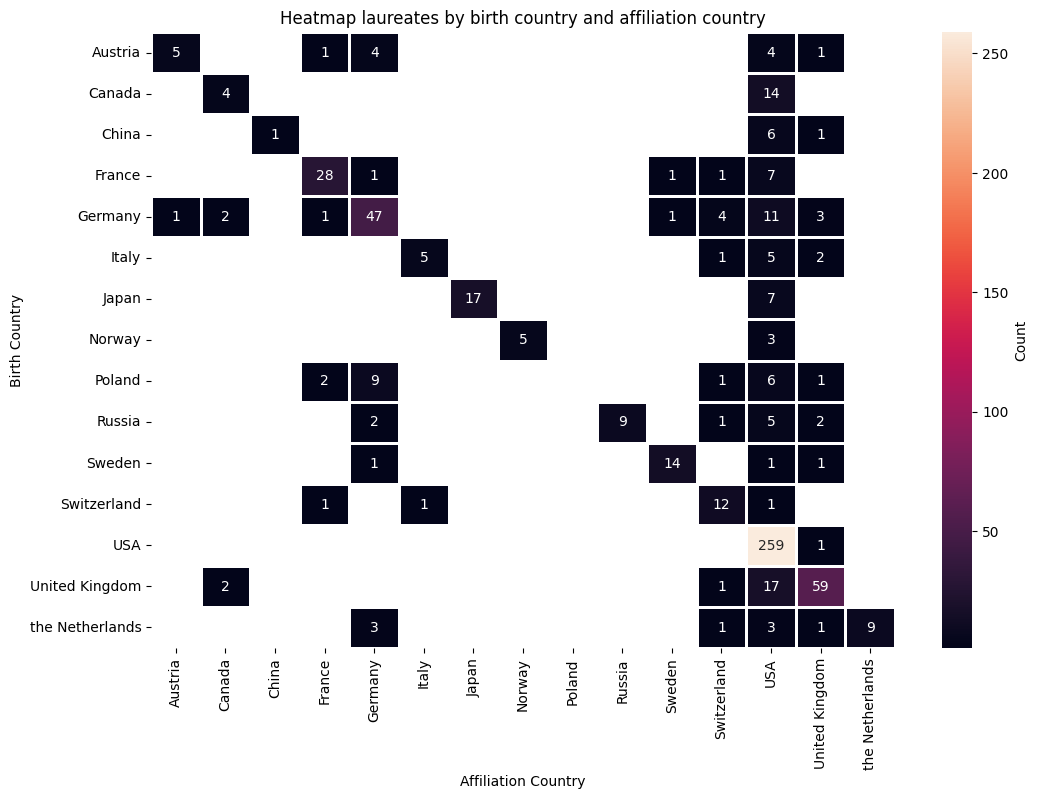

In [317]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(m, mask = (m == 0), annot = True, linewidth=2,fmt='d', cbar_kws={'label': 'Count'})
ax.set(xlabel='Affiliation Country', ylabel='Birth Country',title='Heatmap laureates by birth country and affiliation country')
plt.show()

El grafico se resume en lo siguiente: 

- Para una fila (un paise de nacimiento) a mayor cantidad de cacilleros, menor capacidad de retencion (las personas se fueron a investigar a otro lado)
- Para una columna (un paise de affiliation) a mayor cantidad de cacilleros, mayor capacidad de 'atraccion' (las personas van a investigar alli).


Observar que si naciste en USA y ganaste un premio, lo hiciste para una affiliation de alli (salvo 1 caso). Esto quiere decir que USA tiene un alto nivel de retencion de investigadores.

En cambio Alemania, si bien retiene a la mayoria, tiene repartidos a sus investigadores en universidades de varias partes del mundo.




## Age

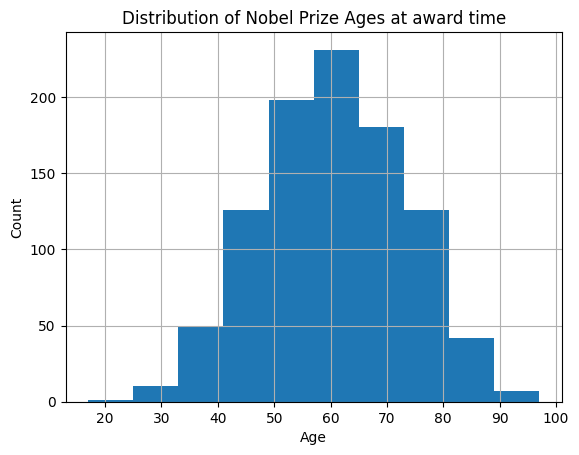

In [318]:
people = df.query("gender != 'organization'")
fig , ax =plt.subplots()

people.age.hist(ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Distribution of Nobel Prize Ages at award time')
plt.show()

Vemos que la distribucion de edades es bastante simetrica (casi normal). La mayoria de los premiados reciben su premio entre los 55-65 anios. Muy pocas personas son premiadas de jovenes o ancianos.

In [319]:
print(people.age.mean())
print(people.age.mode().values[0])
print(people.age.std())

60.256701030927836
56
12.634624132900381


### Age extremes

<Axes: ylabel='age'>

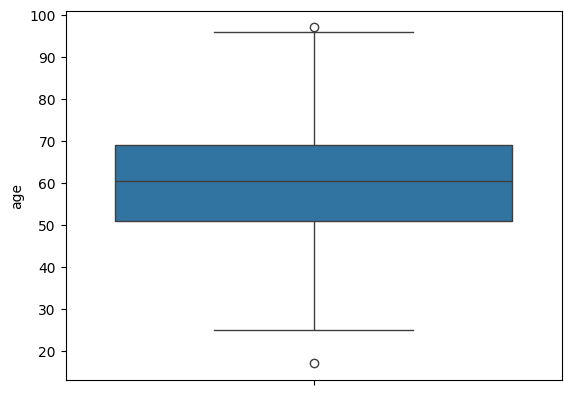

In [320]:
sns.boxplot(people.age)

In [321]:
people[(people.age == people.age.max()) | (people.age == people.age.min())]

,id,name,gender,birth_date,birth_city,birth_country,birth_continent,alive,prize_year,prize_category,prize_sort_order,prize_portion,prize_status,prize_motivation,prize_amount_adjusted,prize_affiliation_name,prize_affiliation_city,prize_affiliation_country,age
486,976,John B. Goodenough,male,1922,Jena,Germany,Europe,0,2019,Chemistry,1,1/3,received,for the development of lithium-ion batteries,10866946,University of Texas,"Austin, TX",USA,97
603,914,Malala Yousafzai,female,1997,Mingora,Pakistan,Asia,1,2014,Peace,2,1/2,received,for their struggle against the suppression of ...,10301676,None,None,None,17


In [322]:
 people.age.max() - people.age.min() # amplitud del rango de edades.

np.int64(80)

Ploteemos por categoria las edades maximas y minimas de los premiados acorde a su genero.

La idea es hacer un vertical barchart por categoria con las 4 edades de cada categoria.  (no se me ocurre como todavia)

In [323]:
ages_category = people.groupby(['prize_category','gender']).aggregate(age_max = ('age','max'),age_min = ('age','min')).reset_index(level=("prize_category",))
ages_category

,prize_category,age_max,age_min
gender,,,
female,Chemistry,70,38
male,Chemistry,97,35
female,Economic Sciences,77,47
male,Economic Sciences,90,51
female,Literature,88,46
male,Literature,85,42
female,Peace,80,17
male,Peace,87,35
female,Physics,65,36


Veamos la distribucion de las edades por categorias.

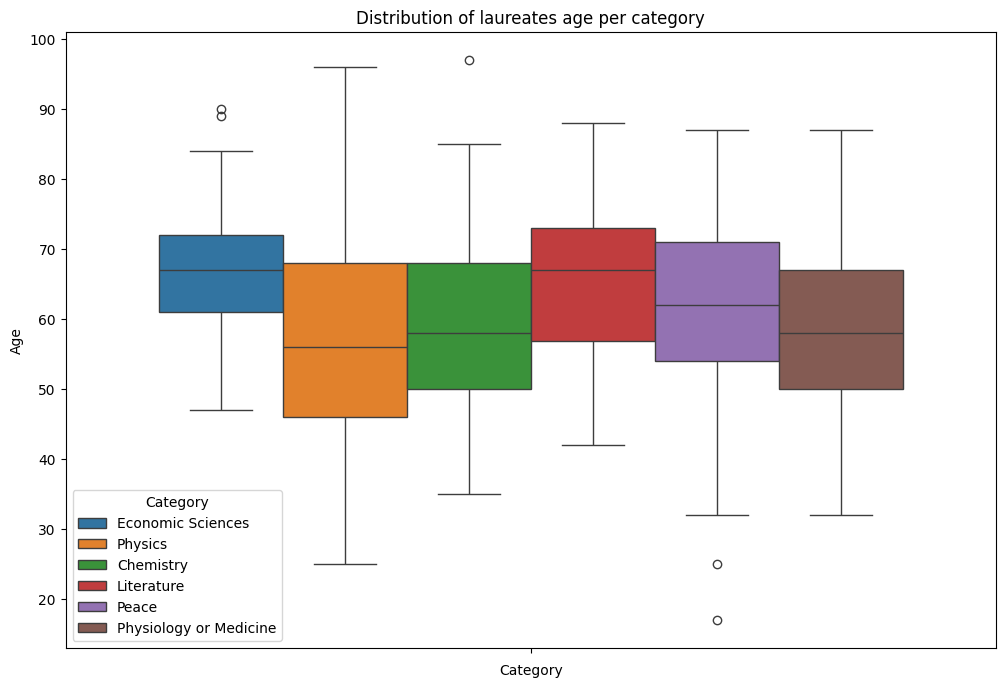

In [324]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(people, y='age', hue='prize_category', ax = ax)
ax.set_xlabel('Category')
ax.set_ylabel('Age')
ax.legend(title='Category')
ax.set_title('Distribution of laureates age per category')
plt.show()

Los premiados en Economia y Literatura lo hacen a mayor edad que las demas. En fisica el rango de la edad es mayor que en todas las demas categorias.

### Age over time

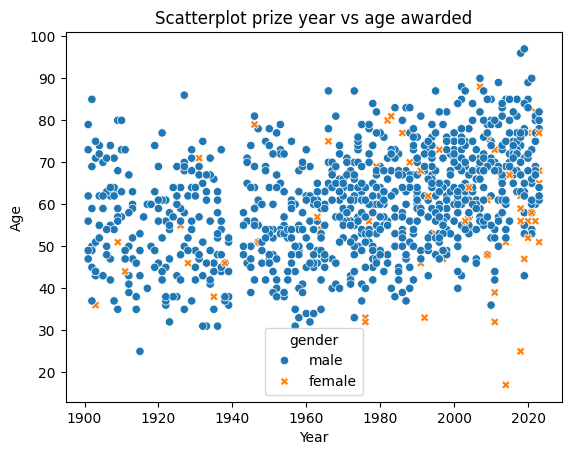

In [325]:
fig, ax = plt.subplots()
sns.scatterplot(people, x='prize_year',y='age', hue='gender', style='gender', ax = ax)
ax.set(title='Scatterplot prize year vs age awarded', xlabel='Year', ylabel='Age')
plt.show()

Separamos por categoria. No se ve mucho pero parece que a medida que paso el tiempo se fueron concentrando los premios en edades mas elevadas.

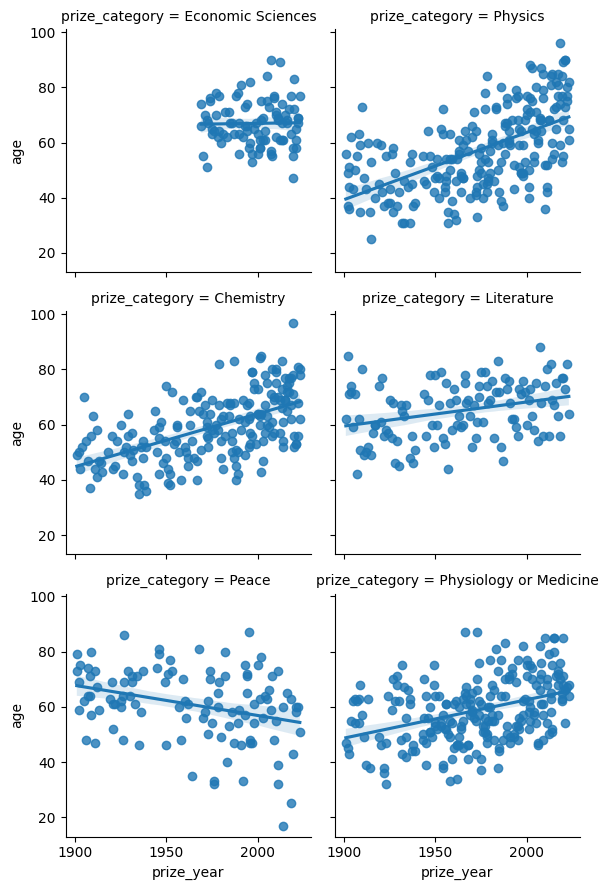

In [326]:
g = sns.FacetGrid(people, col="prize_category", col_wrap = 2)
g.map_dataframe(sns.regplot, x="prize_year", y="age")

Vemos que salvo para las categorias Paz (donde la edad esta disminuyendo) y Economia (donde se mantiene fluctuante entre ~50 y ~90), las edades en que se premia van en aumento.

## Exporto los datos

Me guardo el dataframe como csv para poder tener siempre a mano los datos.

In [327]:
df.to_csv('nobel_data.csv', sep=',', encoding='utf-8', index=False, header=True)